In [1]:
from IPython.display import Image

# GNNs

## Motivação

In [2]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

In [3]:
data_path = pathlib.Path("../../data/cora/")

In [4]:
citations = pd.read_csv(
    data_path / "cora.cites",
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [5]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [6]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    data_path / "cora.content", sep="\t", header=None, names=column_names,
)

In [7]:
# papers.head()
papers.head().T

,0,1,2,3,4
paper_id,31336,1061127,1106406,13195,37879
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


In [8]:
papers["subject"].value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [9]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [10]:
class_values
# class_idx
# paper_idx

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [11]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [12]:
papers.head().T

,0,1,2,3,4
paper_id,462,1911,2002,248,519
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


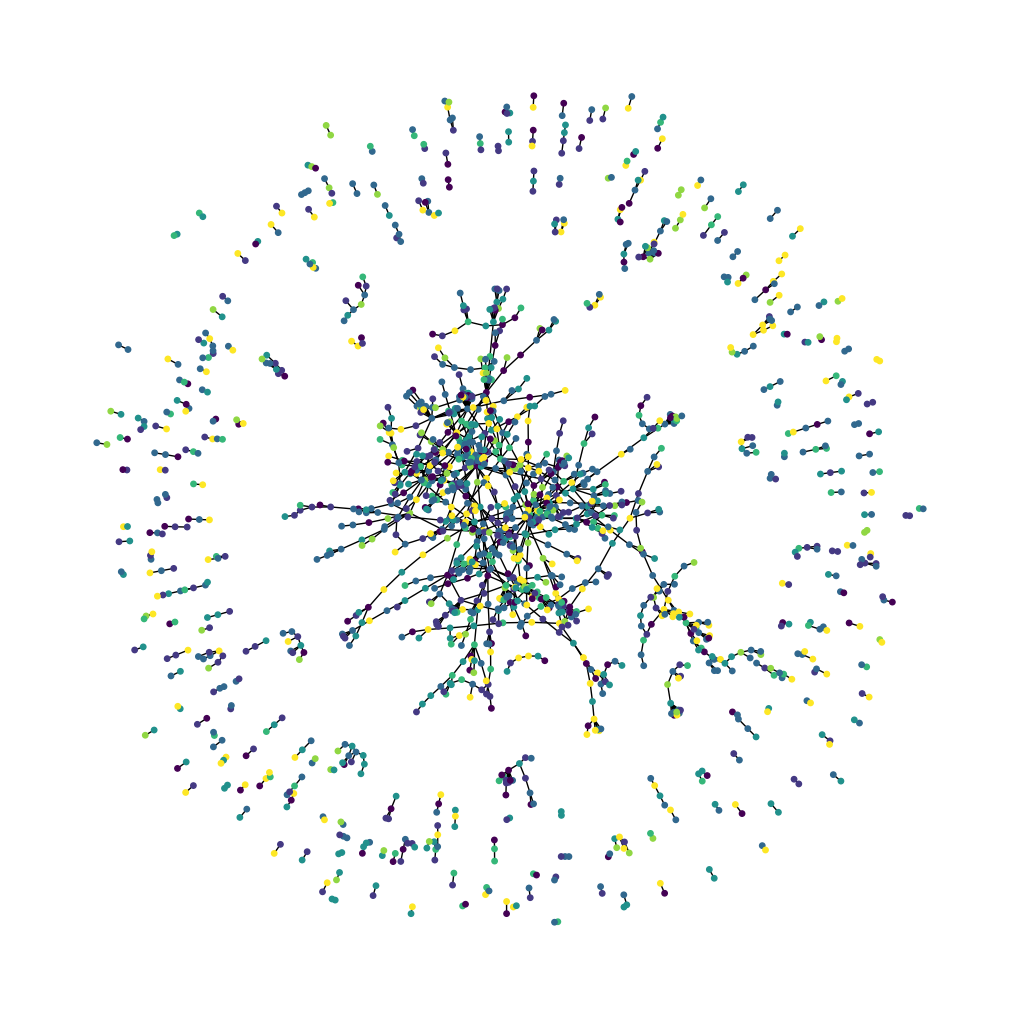

In [13]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


**Problema: Baseado nos termos de um artigo e nos artigos relacionados, conseguimos prever o seu tópico usando uma rede neural?**

## Convoluções em grafos

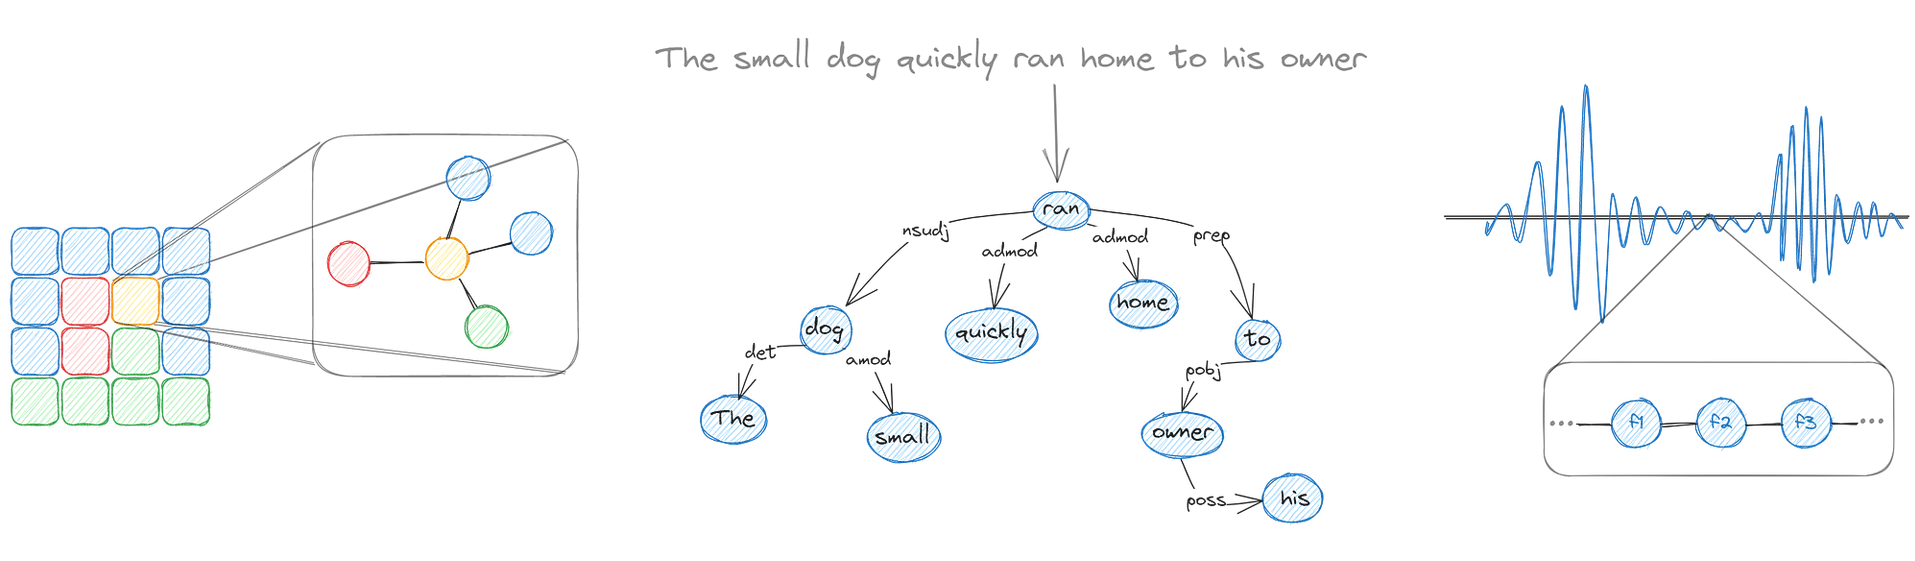

In [14]:
Image(filename='graph_representation.png') 

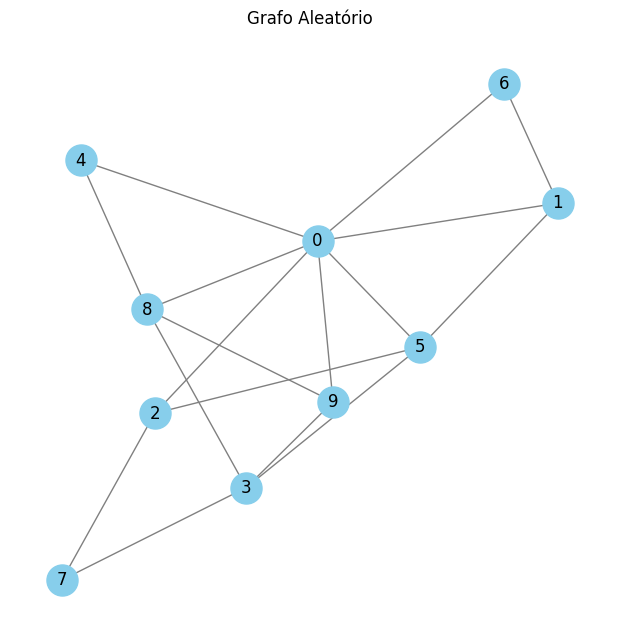

In [15]:
G = nx.erdos_renyi_graph(n=10, p=0.4)

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Aleatório")
plt.show()

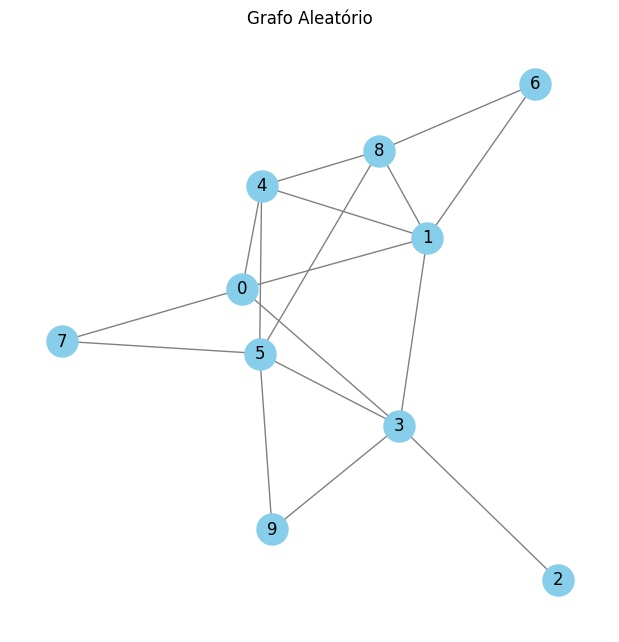

In [16]:
# Gerar um grafo aleatório
G = nx.erdos_renyi_graph(n=10, p=0.4)  # Grafo com 10 nós e probabilidade 0.4 de uma aresta existir

# Plotar o grafo
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Aleatório")
plt.show()

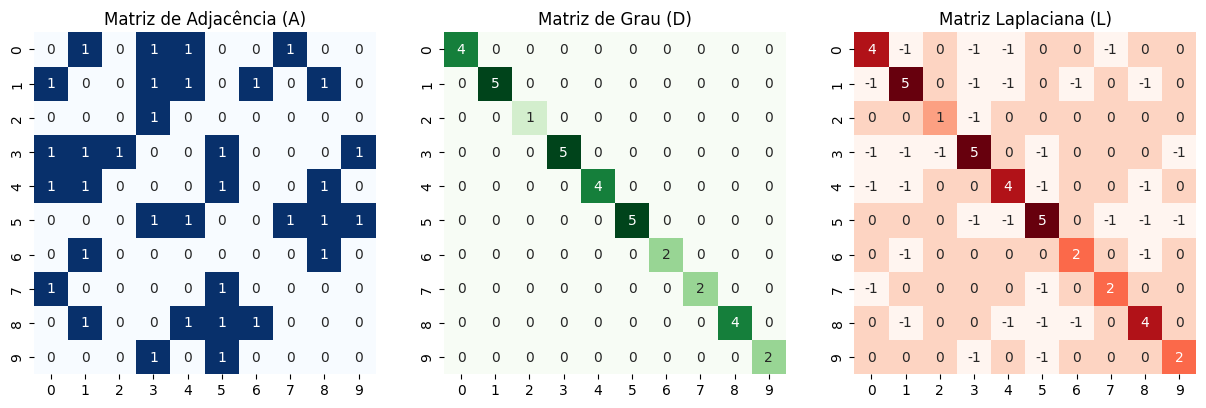

In [17]:
# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Plotar as matrizes como heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Matriz de Adjacência
sns.heatmap(A, ax=axes[0], cmap='Blues', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Adjacência (A)")

# Matriz de Grau
sns.heatmap(D, ax=axes[1], cmap='Greens', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz de Grau (D)")

# Matriz Laplaciana
sns.heatmap(L, ax=axes[2], cmap='Reds', annot=True, cbar=False, square=True)
axes[2].set_title("Matriz Laplaciana (L)")

plt.show()

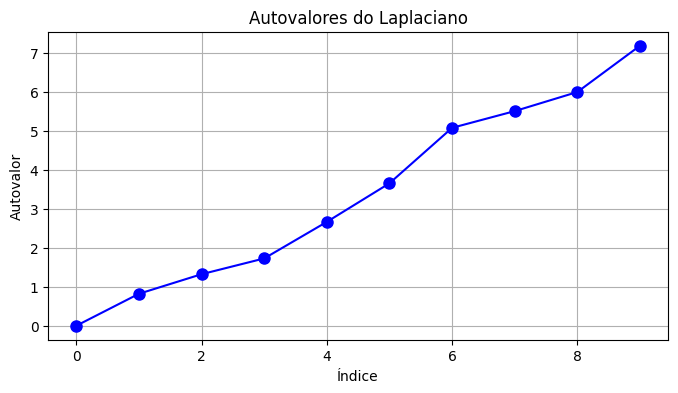

In [18]:
# Autovalores do Laplaciano
eigenvalues = np.linalg.eigvals(L)
eigenvalues_sorted = np.sort(eigenvalues)

# Plotar autovalores
plt.figure(figsize=(8, 4))
plt.plot(eigenvalues_sorted, 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

Podemos decompor $\mathcal{L}$:

$$\mathcal{L} = U \Lambda U^{-1} = U \Lambda U^{\top},$$

onde $U=[u_1,\dots,u_n]$ contém os autovetores de $\mathcal{L}$ e $\Lambda = \text{diag}[\lambda_1,\dots,\lambda_n]$ é uma matriz diagonal conténdo seus respectivos autovalores. 

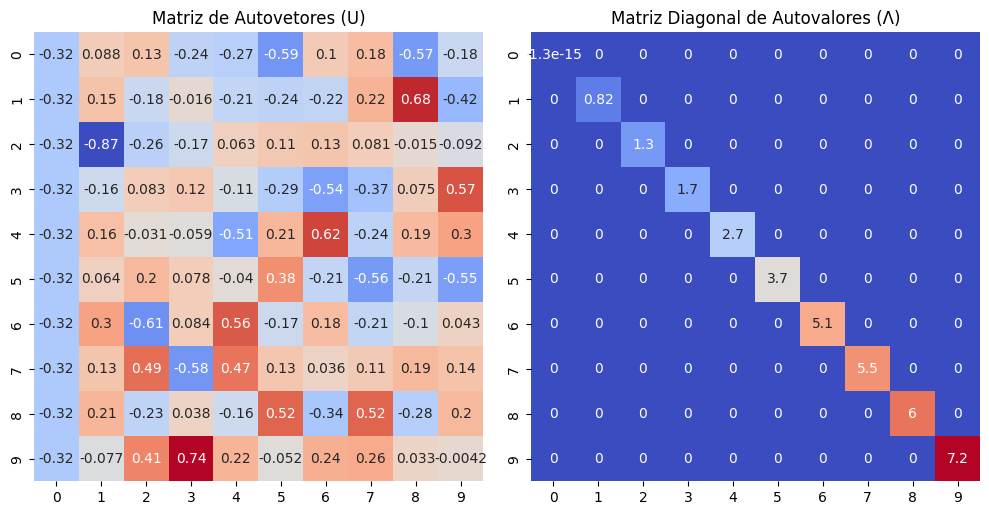

In [19]:
# Calcular autovalores (Lambda) e autovetores (U)
eigenvalues, eigenvectors = np.linalg.eigh(L)  # Use eigh para Laplaciano simétrico

# Criar a matriz diagonal Lambda com os autovalores
Lambda = np.diag(eigenvalues)

# U é a matriz de autovetores (eigenvectors)
U = eigenvectors

# Plotar as matrizes U e Lambda
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot da matriz U (autovetores)
sns.heatmap(U, ax=axes[0], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Autovetores (U)")

# Plot da matriz Lambda (autovalores)
sns.heatmap(Lambda, ax=axes[1], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz Diagonal de Autovalores (Λ)")

plt.tight_layout()
plt.show()

Os autovalores de $\mathbf{L}$ fornecem informações ainda mais significativas do que o esperado. Por exemplo, ao ordenar e rotular os autovalores de modo que $\lambda_1$ corresponda ao menor autovalor, observa-se que este valor é sempre zero. Esta ocorrência não é acidental; a multiplicidade do autovalor zero está associada ao número de componentes conexas no grafo. Especificamente, se $\lambda_2 > 0$, então o grafo é conexo. Por outro lado, a multiplicidade de $\lambda = 2$ como autovalor corresponde ao número de componentes bipartidas conectadas no grafo que possuem pelo menos dois vértices.


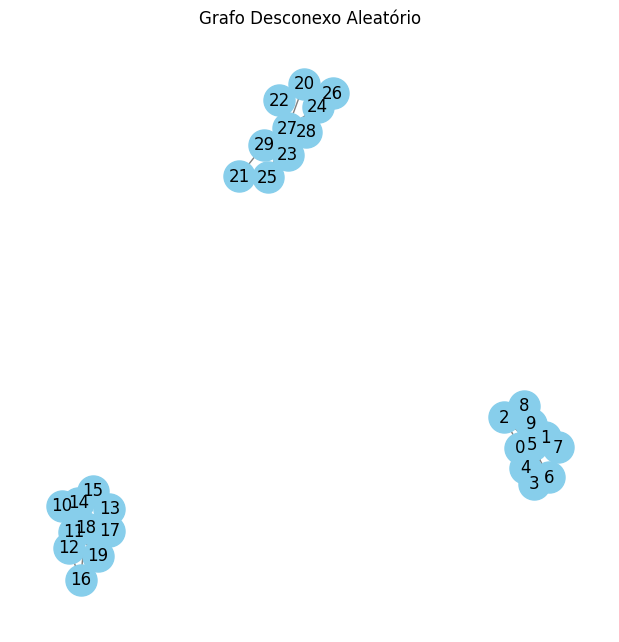

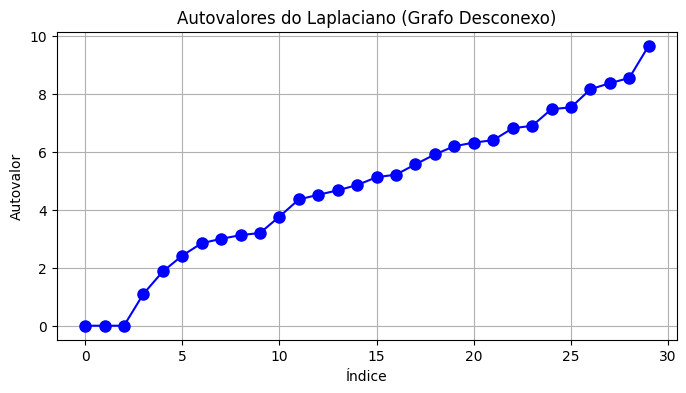

Autovalores do Laplaciano (Grafo Desconexo):
 [-5.53010871e-16 -1.56507583e-16  1.21800034e-15  1.09760623e+00
  1.87324061e+00  2.41990534e+00  2.84889224e+00  3.00000000e+00
  3.12655438e+00  3.20268392e+00  3.76751571e+00  4.36056551e+00
  4.52063482e+00  4.67408811e+00  4.85712235e+00  5.12783388e+00
  5.21741604e+00  5.57186778e+00  5.91592156e+00  6.19716498e+00
  6.32212071e+00  6.40531283e+00  6.81966459e+00  6.90076079e+00
  7.47752937e+00  7.53756167e+00  8.16467617e+00  8.37215769e+00
  8.55460450e+00  9.66659824e+00]


In [20]:
# Gerar um grafo desconexo aleatório
# Aqui, usamos dois componentes desconexos: dois grafos Erdős-Rényi independentes
G1 = nx.erdos_renyi_graph(n=10, p=0.5)  # Primeiro componente
G2 = nx.erdos_renyi_graph(n=10, p=0.5)  # Segundo componente
G3 = nx.erdos_renyi_graph(n=10, p=0.5)  # Segundo componente

# Unir os dois grafos em um grafo desconexo
G = nx.disjoint_union(G1, G2)
G = nx.disjoint_union(G, G3)

# Plotar o grafo desconexo
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Desconexo Aleatório")
plt.show()

# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Calcular autovalores (Lambda) e autovetores (U)
eigenvalues, eigenvectors = np.linalg.eigh(L)  # Use eigh para Laplaciano simétrico

# Criar a matriz diagonal Lambda com os autovalores
Lambda = np.diag(eigenvalues)

# Plotar os autovalores
plt.figure(figsize=(8, 4))
plt.plot(np.sort(eigenvalues), 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano (Grafo Desconexo)")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

# Mostrar os autovalores
print("Autovalores do Laplaciano (Grafo Desconexo):\n", np.sort(eigenvalues))



### Um pouco de matemática

Se temos um espaço de Hilbert $\mathcal{H}$ e uma base ortonormal $\{u_i\}_{i=1}^\infty$ então dado $x\in \mathcal{H}$:
$$ \{\langle x,u_i\rangle\}_{i=1}^\infty $$
são os coeficientes de Fourier dado a base em questão e 
$$\sum \langle x,u_i\rangle u_i \to x.$$

Vamos definir a tranformada de Fourier dessa forma:

$$ \mathcal{F}[x][\ell] = \hat{x}_\ell = \langle x, u_\ell\rangle = \sum_i^n x^i u_\ell^i.$$

Em forma matricial, isso é igual 
$$ \hat{x} = U^T x.$$

De forma similar, sua invesa é

$$x = U\hat{x}. $$

Em resumo, a transformada de Fourier no grafo utiliza os autovetores da matriz laplaciana para permitir a representação de um sinal em dois domínios distintos: o domínio dos vértices e o domínio espectral do grafo. 

__Só mais um pouco de matemática...__

$$\mathcal{F}[y*x] = \mathcal{F}[y] \odot \mathcal{F}[x] $$

Logo, 

$$ y*x =  \mathcal{F}^{-1}[\mathcal{F}[y] \odot \mathcal{F}[x]]$$

Mas pela análise acima, isso é igual à

$$ y*x =  U(U^t y \odot U^t x).$$

Isso é igual à

$$ y*x =  U y_\theta(\Lambda) U^t x,.$$

onde


$$y_\theta(\Lambda) = \text{diag}(U^t y).$$

Dessa forma, a convolução espectral de x com um y é dada por:

$$ y*x = U y_\theta(\Lambda)U^T x$$ 

onde 

$$y_\theta(\Lambda) = \text{diag}([\theta_1,\dots,\theta_n])$$

são os valores $\theta$ que vamos aprender!



## Primeira ideia

$$f_j^{(k+1)} = \sigma \left( \sum_{i=1}^{C_k} U_d \Sigma^{(k)} g_0 U_d^T f_i^{(k)} \right) = \sigma \left( \sum_{i=1}^{C_k} U_d \Sigma^{(k)} g_0 f_i \right) $$

## Aplicação

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

In [22]:
# Load Cora dataset
dataset = Planetoid(root='/tmp/cora', name='Cora')

Processing...
Done!


In [23]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=32).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [25]:
import matplotlib.pyplot as plt

# Listas para armazenar os valores de perda e acurácia
train_losses = []
test_losses = []
test_accuracies = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return loss.item(), acc

n_epoch = 500
# Loop de treinamento e teste
for epoch in range(1, n_epoch):
    train_loss = train()
    test_loss, acc = test()
    
    # Armazenando os valores
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(acc)
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 001, Train Loss: 3.4603, Test Loss: 3.3886, Accuracy: 0.3330
Epoch: 002, Train Loss: 3.3491, Test Loss: 3.3247, Accuracy: 0.4140
Epoch: 003, Train Loss: 3.2524, Test Loss: 3.2589, Accuracy: 0.4480
Epoch: 004, Train Loss: 3.1259, Test Loss: 3.1894, Accuracy: 0.4710
Epoch: 005, Train Loss: 2.9814, Test Loss: 3.1146, Accuracy: 0.5040
Epoch: 006, Train Loss: 2.8727, Test Loss: 3.0399, Accuracy: 0.5200
Epoch: 007, Train Loss: 2.8260, Test Loss: 2.9678, Accuracy: 0.5470
Epoch: 008, Train Loss: 2.6459, Test Loss: 2.8986, Accuracy: 0.5710
Epoch: 009, Train Loss: 2.5258, Test Loss: 2.8317, Accuracy: 0.5940
Epoch: 010, Train Loss: 2.6202, Test Loss: 2.7689, Accuracy: 0.6110
Epoch: 011, Train Loss: 2.3379, Test Loss: 2.7091, Accuracy: 0.6340
Epoch: 012, Train Loss: 2.4027, Test Loss: 2.6532, Accuracy: 0.6580
Epoch: 013, Train Loss: 2.3495, Test Loss: 2.6017, Accuracy: 0.6740
Epoch: 014, Train Loss: 2.1603, Test Loss: 2.5533, Accuracy: 0.6930
Epoch: 015, Train Loss: 2.2699, Test Loss: 2.508

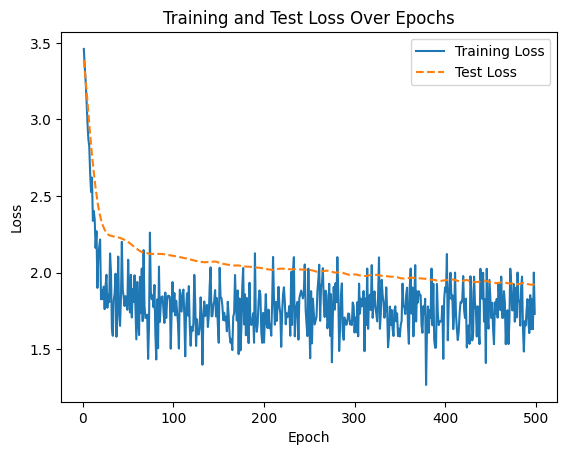

In [26]:
# Plotando as curvas de perda
epochs = range(1, n_epoch)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

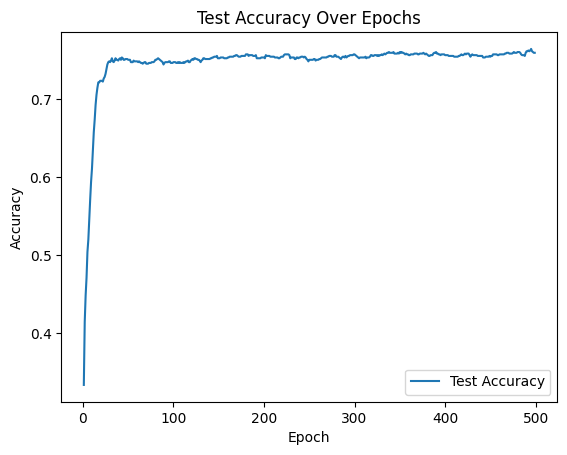

In [27]:
# Plotando a curva de acurácia
plt.figure()
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

### Diferença nos dados

In [28]:
papers.shape, citations.shape

((2708, 1435), (5429, 2))

In [29]:
# Como é nosso dataset
dataset[0].x.shape

torch.Size([2708, 1433])

In [30]:
dataset[0].edge_index.shape

torch.Size([2, 10556])

In [31]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

### t-sne Embedding

In [35]:
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

In [36]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels):
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    
    # Plotando
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Cora Embeddings")
    plt.show()

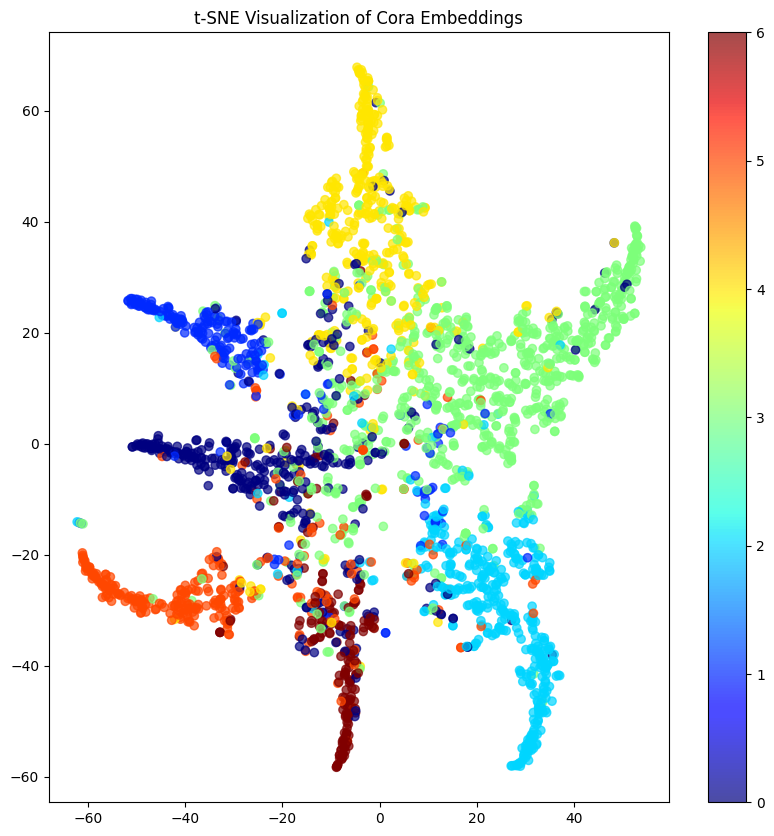

In [37]:
plot_tsne(embeddings, data.y.cpu())

In [ ]:
# https://danielegrattarola.github.io/posts/2021-03-12/gnn-lecture-part-2.html